# Predicting Early Subscriber Churn (Streaming) — Portfolio Case Study

**Executive summary (Jan–Apr 2023 cohort, ~29.7K subs)**  
- Churn is concentrated immediately after **Month 1**; retention stabilizes after Month 2.  
- **Not all engagement equals loyalty**: many rapid churners exhibit high first‑month activity consistent with a “binge‑and‑leave” pattern.  
- Acquisition and billing paths show meaningful retention differences; rollups drive actionability while granular cuts diagnose root causes.  
- Built an interpretable baseline (**logistic regression**) and a non-linear comparison model (**random forest**) to prioritize high‑risk cohorts.

> **Disclaimer:** This is an interview-style case study using provided (synthetic/anonymized) data. No proprietary information is included.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from scipy.interpolate import PchipInterpolator

pd.set_option("display.max_columns", 200)

DATA_PATH = '/Users/williamgieng/Desktop/Philo_Assessment/subscriber_data_exercise__candidate_set.csv'  # adjust if needed
ANCHOR_DATE = pd.Timestamp("2023-01-01")  # Month 1 = January 2023
MAX_MONTH = 4  # cap at April 2023 (data window ends mid-April)

CHURN_STATUSES = {"deactivated", "deleted", "lapsed", "locked_out", "blocked"}


In [4]:
# Load data
df = pd.read_csv(DATA_PATH)

print("shape:", df.shape)
display(df.head(3))


shape: (29691, 34)


,account_id,last_billing_platform_used,last_subscription_status,created_at,dma_code,dma_region,dma_name,age_range,has_email,has_phone,direct_billed,demographic_gender,demographic_homeowner,demographic_people_in_household,demographic_household_composition,demographic_education_level,demographic_income,demographic_age_range,user_state,total_payments,total_paid,first_payment_at,total_refunds,total_refunded,trial_started_at,trial_ended_at,acquisition_biller,signup_platform,distinct_channels,distinct_shows,hours_watched,shows_saved,stream_starts,payment_months
0,140477,external_a,regular,12/25/22 5:19,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Active,4.0,109.96,1/11/23 11:07,NaN,NaN,12/25/22 5:19,1/1/23 5:19,external_a,tv_platform_c,31.0,95.0,1522.5777,3.0,1104.0,"2023-01-01 00:00:00, 2023-02-01 00:00:00, 2023..."
1,179440,external_b,deactivated,1/1/23 20:07,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Churned,1.0,24.99,1/8/23 13:31,NaN,NaN,1/1/23 21:27,1/8/23 21:27,external_b,mobile_b,22.0,41.0,17.0482,0.0,48.0,1/1/23 0:00
2,156674,external_b,regular,4/23/22 19:06,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Active,4.0,99.96,1/9/23 3:02,NaN,NaN,4/23/22 19:07,4/30/22 19:07,external_b,tv_platform_e,6.0,9.0,56.7884,1.0,50.0,"2023-01-01 00:00:00, 2023-02-01 00:00:00, 2023..."


## Data overview & key fields

We treat **tenure** as the number of observed payment months (`total_payments`).  
Because the dataset ends in mid‑April 2023, survival curves are explicitly **capped at Month 4** for interpretability.


In [5]:
# Basic cleaning / types
df["total_payments"] = pd.to_numeric(df["total_payments"], errors="coerce").fillna(0).astype(int)

# Rollups for actionability
def signup_platform_rollup(x: str) -> str:
    x = (x or "").lower()
    if x.startswith("mobile"):
        return "mobile"
    if x.startswith("tv_platform"):
        return "tv_platform"
    if x.startswith("web"):
        return "web"
    return "unknown"

def billing_rollup(x: str) -> str:
    x = (x or "").lower()
    if x.startswith("internal"):
        return "internal"
    if x.startswith("external"):
        return "external"
    return "unknown"

df["signup_platform_rollup"] = df["signup_platform"].astype(str).map(signup_platform_rollup)
df["acquisition_biller_rollup"] = df["acquisition_biller"].astype(str).map(billing_rollup)
df["last_billing_platform_rollup"] = df["last_billing_platform_used"].astype(str).map(billing_rollup)

# Engagement normalization (per active month) to compare subscribers with different tenures
eng_cols = ["hours_watched", "stream_starts", "distinct_shows", "distinct_channels", "shows_saved"]
for c in eng_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

denom = df["total_payments"].replace(0, np.nan)
for c in eng_cols:
    df[f"{c}_per_month"] = df[c] / denom

# Fill NaNs produced by division (e.g., 0 payments) with 0 for modeling/plots
for c in [f"{x}_per_month" for x in eng_cols]:
    df[c] = df[c].fillna(0.0)

# Basic segment flags
df["is_refunded_only"] = (df["total_payments"] == 0) & (df["total_refunds"].fillna(0) > 0)
df["is_churn_status"] = df["last_subscription_status"].isin(CHURN_STATUSES)

df["segment"] = np.select(
    [
        df["is_refunded_only"],
        (df["total_payments"] == 1) & df["is_churn_status"],
        (df["total_payments"] == 2) & df["is_churn_status"],
        (df["total_payments"] >= 3),
    ],
    [
        "refunded/trial_only",
        "rapid_churner_1mo",
        "moderate_churner_2mo",
        "retained_3mo_plus",
    ],
    default="other"
)

df["segment"].value_counts(dropna=False)


segment
retained_3mo_plus       15178
rapid_churner_1mo        9850
moderate_churner_2mo     3581
refunded/trial_only       830
other                     252
Name: count, dtype: int64

## Engagement patterns

Key question: **Can we detect “binge-and-leave” behavior early?**  
We compare normalized engagement (per active month) across segments.


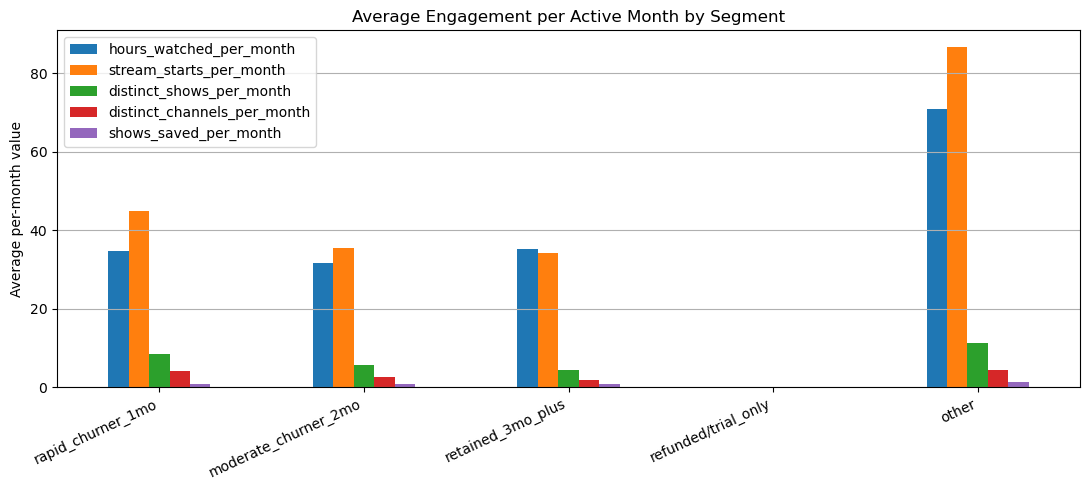

In [6]:
seg_order = ["rapid_churner_1mo", "moderate_churner_2mo", "retained_3mo_plus", "refunded/trial_only", "other"]
plot_cols = ["hours_watched_per_month", "stream_starts_per_month", "distinct_shows_per_month", "distinct_channels_per_month", "shows_saved_per_month"]

seg_means = (
    df.groupby("segment")[plot_cols]
      .mean()
      .reindex(seg_order)
)

ax = seg_means.plot(kind="bar", figsize=(11,5))
ax.set_title("Average Engagement per Active Month by Segment")
ax.set_xlabel("")
ax.set_ylabel("Average per-month value")
ax.grid(True, axis="y")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


## Survival analysis (capped at Month 4)

Because we only observe payments through **mid‑April 2023**, we cap survival at Month 4:
- Subscribers with `total_payments >= 4` are **right‑censored** at Month 4.
- A churn event occurs when `last_subscription_status` indicates churn and `total_payments <= 4`.

We compute a **monthly discrete survival curve** (0–4) and then apply **PCHIP smoothing** for presentation.


In [7]:
def set_month_axis(ax, max_month=4, anchor_date=pd.Timestamp("2023-01-01")):
    ticks = np.arange(0, max_month + 1)
    labels = ["Month 0"] + [
        f"Month {i} ({(anchor_date + pd.DateOffset(months=i-1)).strftime('%B %Y')})"
        for i in ticks[1:]
    ]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=35, ha="right")

def prepare_survival_frame(df_in: pd.DataFrame) -> pd.DataFrame:
    out = df_in.copy()
    out["duration"] = out["total_payments"].clip(upper=MAX_MONTH).astype(int)
    # event happens at observed duration <= MAX_MONTH if churn status
    out["event"] = (out["last_subscription_status"].isin(CHURN_STATUSES)) & (out["total_payments"] <= MAX_MONTH)
    out["event"] = out["event"].astype(int)
    # right-censor anyone beyond MAX_MONTH
    out.loc[out["total_payments"] >= MAX_MONTH, "duration"] = MAX_MONTH
    out.loc[out["total_payments"] >= MAX_MONTH, "event"] = 0
    return out[["duration", "event"]].join(out.drop(columns=["duration","event"]))

def monthly_survival_points(df_surv: pd.DataFrame) -> pd.DataFrame:
    # returns survival at integer months 0..MAX_MONTH
    surv = [1.0]
    s = 1.0
    for m in range(1, MAX_MONTH + 1):
        at_risk = (df_surv["duration"] >= m).sum()
        events = ((df_surv["duration"] == m) & (df_surv["event"] == 1)).sum()
        h = (events / at_risk) if at_risk > 0 else 0.0
        s *= (1.0 - h)
        surv.append(s)
    return pd.DataFrame({"month": np.arange(0, MAX_MONTH + 1), "survival": surv})

def plot_smoothed_survival(ax, points_df: pd.DataFrame, label: str):
    x = points_df["month"].values.astype(float)
    y = points_df["survival"].values.astype(float)

    # Smooth with PCHIP (shape-preserving), enforce bounds and monotone non-increasing
    t_fine = np.linspace(x.min(), x.max(), 240)
    y_s = PchipInterpolator(x, y)(t_fine)
    y_s = np.clip(y_s, 0, 1)
    y_s = np.minimum.accumulate(y_s)

    ax.plot(t_fine, y_s, label=label)
    ax.scatter(x, y, s=28)


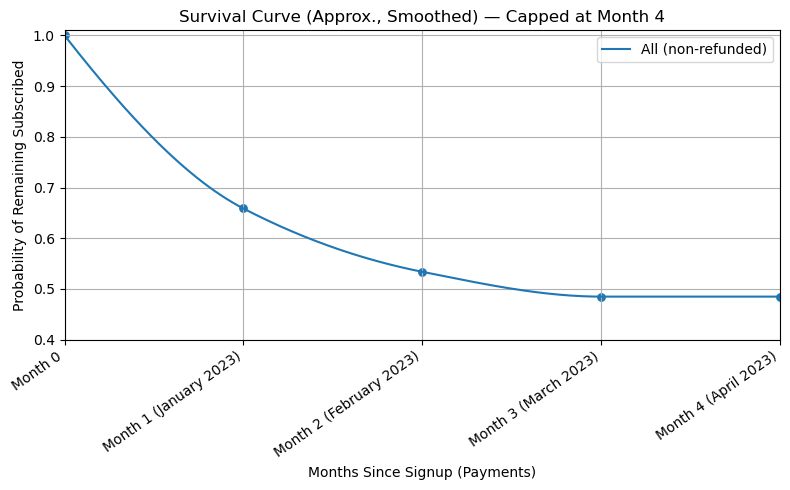

,month,survival
0,0,1.000000
1,1,0.658709
2,2,0.533824
3,3,0.484901
4,4,0.484901


In [8]:
df_surv = prepare_survival_frame(df)

pts = monthly_survival_points(df_surv)

fig, ax = plt.subplots(figsize=(8,5))
plot_smoothed_survival(ax, pts, "All (non-refunded)")

ax.set_title("Survival Curve (Approx., Smoothed) — Capped at Month 4")
ax.set_xlabel("Months Since Signup (Payments)")
ax.set_ylabel("Probability of Remaining Subscribed")
ax.set_ylim(0.40, 1.01)
ax.set_xlim(0, MAX_MONTH)
set_month_axis(ax, MAX_MONTH, ANCHOR_DATE)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

display(pts)


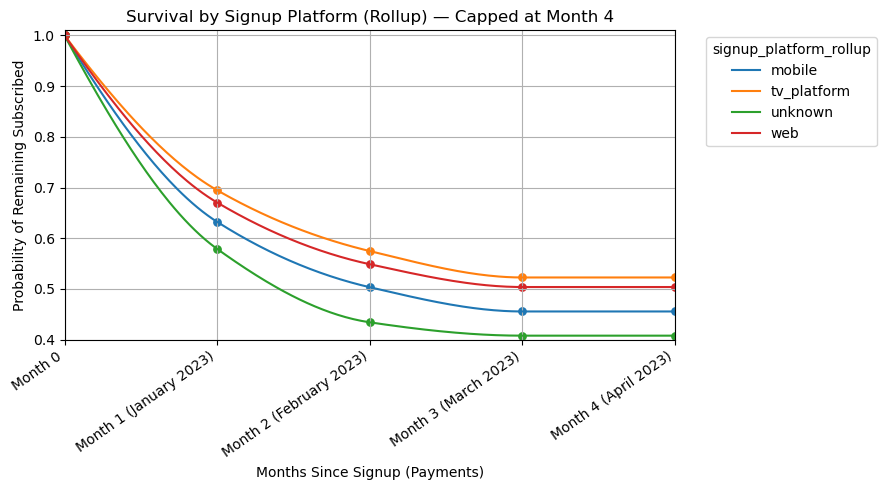

In [9]:
fig, ax = plt.subplots(figsize=(9,5))

for grp, gdf in df_surv.groupby("signup_platform_rollup"):
    if len(gdf) < 50:
        continue
    pts = monthly_survival_points(gdf)
    plot_smoothed_survival(ax, pts, grp)

ax.set_title("Survival by Signup Platform (Rollup) — Capped at Month 4")
ax.set_xlabel("Months Since Signup (Payments)")
ax.set_ylabel("Probability of Remaining Subscribed")
ax.set_ylim(0.40, 1.01)
ax.set_xlim(0, MAX_MONTH)
set_month_axis(ax, MAX_MONTH, ANCHOR_DATE)
ax.grid(True)
ax.legend(title="signup_platform_rollup", bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()


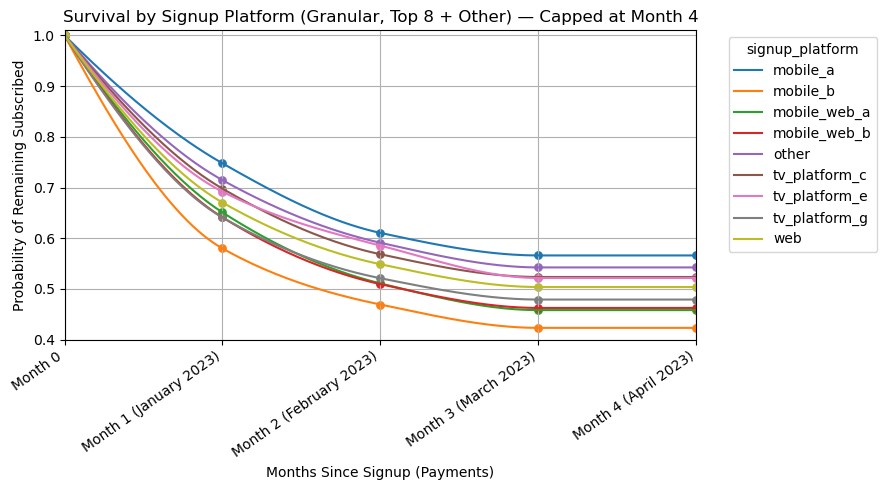

In [10]:
# Granular signup platforms: show Top N by volume, group the rest as 'other'
TOP_N = 8
top_vals = df["signup_platform"].value_counts().head(TOP_N).index.tolist()

df_surv["signup_platform_top"] = np.where(df_surv["signup_platform"].isin(top_vals),
                                         df_surv["signup_platform"],
                                         "other")

fig, ax = plt.subplots(figsize=(9,5))

for grp, gdf in df_surv.groupby("signup_platform_top"):
    if len(gdf) < 50:
        continue
    pts = monthly_survival_points(gdf)
    plot_smoothed_survival(ax, pts, grp)

ax.set_title(f"Survival by Signup Platform (Granular, Top {TOP_N} + Other) — Capped at Month 4")
ax.set_xlabel("Months Since Signup (Payments)")
ax.set_ylabel("Probability of Remaining Subscribed")
ax.set_ylim(0.40, 1.01)
ax.set_xlim(0, MAX_MONTH)
set_month_axis(ax, MAX_MONTH, ANCHOR_DATE)
ax.grid(True)
ax.legend(title="signup_platform", bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()


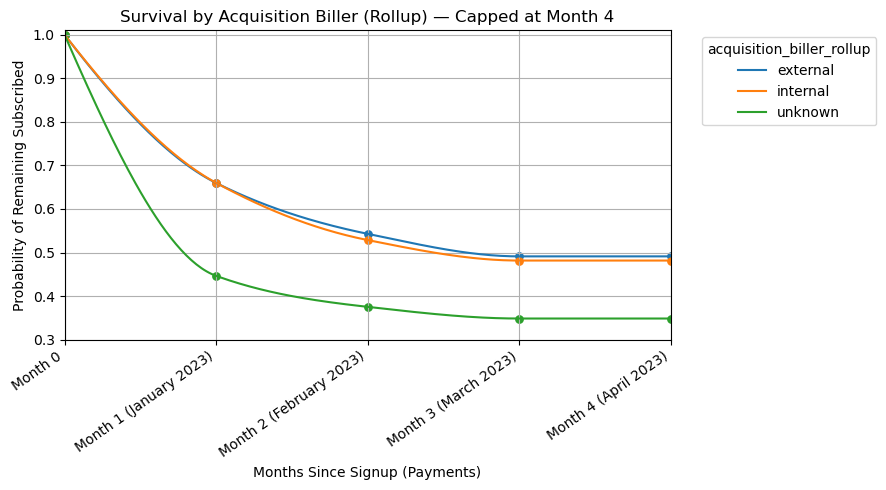

In [12]:
fig, ax = plt.subplots(figsize=(9,5))

for grp, gdf in df_surv.groupby("acquisition_biller_rollup"):
    if len(gdf) < 50:
        continue
    pts = monthly_survival_points(gdf)
    plot_smoothed_survival(ax, pts, grp)

ax.set_title("Survival by Acquisition Biller (Rollup) — Capped at Month 4")
ax.set_xlabel("Months Since Signup (Payments)")
ax.set_ylabel("Probability of Remaining Subscribed")
ax.set_ylim(0.30, 1.01)
ax.set_xlim(0, MAX_MONTH)
set_month_axis(ax, MAX_MONTH, ANCHOR_DATE)
ax.grid(True)
ax.legend(title="acquisition_biller_rollup", bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()


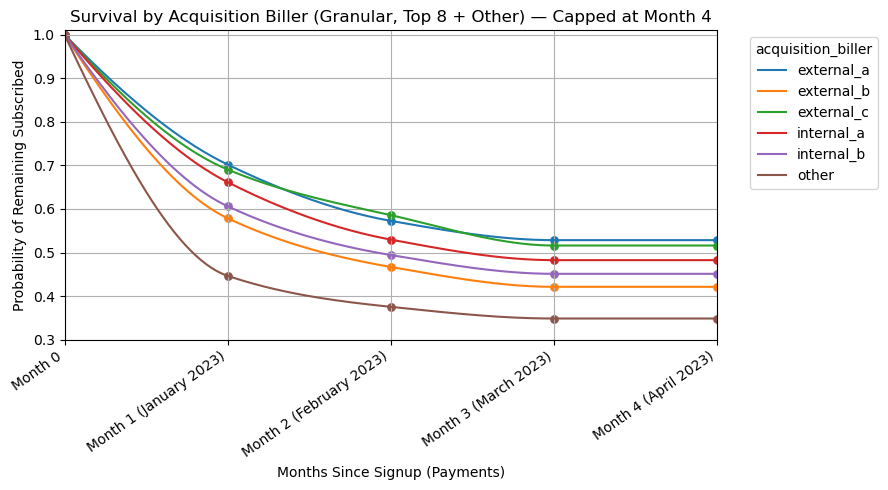

In [14]:
TOP_N = 8
top_vals = df["acquisition_biller"].value_counts().head(TOP_N).index.tolist()

df_surv["acquisition_biller_top"] = np.where(df_surv["acquisition_biller"].isin(top_vals),
                                            df_surv["acquisition_biller"],
                                            "other")

fig, ax = plt.subplots(figsize=(9,5))

for grp, gdf in df_surv.groupby("acquisition_biller_top"):
    if len(gdf) < 50:
        continue
    pts = monthly_survival_points(gdf)
    plot_smoothed_survival(ax, pts, grp)

ax.set_title(f"Survival by Acquisition Biller (Granular, Top {TOP_N} + Other) — Capped at Month 4")
ax.set_xlabel("Months Since Signup (Payments)")
ax.set_ylabel("Probability of Remaining Subscribed")
ax.set_ylim(0.30, 1.01)
ax.set_xlim(0, MAX_MONTH)
set_month_axis(ax, MAX_MONTH, ANCHOR_DATE)
ax.grid(True)
ax.legend(title="acquisition_biller", bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Predictive modeling (Rapid churners vs retained)

For modeling, we focus on a practical decision: **flag subscribers likely to churn after Month 1**.

- Positive class: churn status + `total_payments == 1`  
- Negative class: `total_payments >= 3` (retained)  
- We compare:
  - **Logistic Regression** (interpretable baseline)
  - **Random Forest** (non-linear benchmark)

> Note: With limited early-life features (weekly engagement, richer lifecycle signals), performance is expected to be modest.


In [15]:
# Build modeling dataset (Rapid Churners vs Retained)
pos = (df["segment"] == "rapid_churner_1mo")
neg = (df["segment"] == "retained_3mo_plus")

df_model = df[pos | neg].copy()
df_model["y"] = np.where(pos[pos | neg], 1, 0)

feature_cols_num = [
    "hours_watched_per_month",
    "stream_starts_per_month",
    "distinct_shows_per_month",
    "distinct_channels_per_month",
    "shows_saved_per_month",
    "total_refunds",
    "total_refunded",
]
feature_cols_cat = [
    "signup_platform_rollup",
    "acquisition_biller_rollup",
    "last_billing_platform_rollup",
    "direct_billed",
    "has_email",
    "has_phone",
]

for c in ["direct_billed", "has_email", "has_phone"]:
    df_model[c] = df_model[c].fillna(0).astype(int)

X = df_model[feature_cols_num + feature_cols_cat]
y = df_model["y"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
        ]), feature_cols_num),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]), feature_cols_cat),
    ]
)
logreg = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight="balanced_subsample",
        min_samples_leaf=20,
        n_jobs=-1
    ))
])

models = {"Logistic Regression": logreg, "Random Forest": rf}

def eval_model(name, pipe):
    pipe.fit(X_train, y_train)
    p = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:, 1]

    out = {
        "model": name,
        "accuracy": accuracy_score(y_test, p),
        "precision": precision_score(y_test, p),
        "recall": recall_score(y_test, p),
        "roc_auc": roc_auc_score(y_test, proba),
    }
    return out, p, proba, pipe

results = []
fitted = {}
for name, pipe in models.items():
    out, p, proba, fitted_pipe = eval_model(name, pipe)
    results.append(out)
    fitted[name] = (p, proba, fitted_pipe)

pd.DataFrame(results).sort_values("roc_auc", ascending=False)

,model,accuracy,precision,recall,roc_auc
1,Random Forest,0.856481,0.748808,0.956151,0.949074
0,Logistic Regression,0.693783,0.626328,0.550548,0.754294


In [16]:
# Diagnostics: confusion matrix + short report for the top model
best_name = pd.DataFrame(results).sort_values("roc_auc", ascending=False).iloc[0]["model"]
p, proba, best_pipe = fitted[best_name]

print("Best model:", best_name)
print("Confusion matrix:\n", confusion_matrix(y_test, p))
print("\nClassification report:\n", classification_report(y_test, p, digits=3))


Best model: Random Forest
Confusion matrix:
 [[3004  790]
 [ 108 2355]]

Classification report:
               precision    recall  f1-score   support

           0      0.965     0.792     0.870      3794
           1      0.749     0.956     0.840      2463

    accuracy                          0.856      6257
   macro avg      0.857     0.874     0.855      6257
weighted avg      0.880     0.856     0.858      6257



### Model interpretability

- Logistic regression: inspect top positive/negative coefficients  
- Random forest: inspect feature importances (global)

This is not “model worship”; it’s about translating signals into **retention actions**.


In [17]:
# Extract feature names after preprocessing (one-hot inside the categorical pipeline)
cat_pipe = best_pipe.named_steps["prep"].named_transformers_["cat"]
ohe = cat_pipe.named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(feature_cols_cat)

all_feature_names = list(cat_feature_names) + feature_cols_num

model = best_pipe.named_steps["model"]

if hasattr(model, "coef_"):
    coefs = model.coef_[0]
    coef_df = pd.DataFrame({"feature": all_feature_names, "coef": coefs}).sort_values("coef", ascending=False)
    display(coef_df.head(15))
    display(coef_df.tail(15))

if hasattr(model, "feature_importances_"):
    imps = model.feature_importances_
    imp_df = pd.DataFrame({"feature": all_feature_names, "importance": imps}).sort_values("importance", ascending=False)
    display(imp_df.head(20))


,feature,importance
3,signup_platform_rollup_web,0.408180
2,signup_platform_rollup_unknown,0.235804
4,acquisition_biller_rollup_external,0.176595
0,signup_platform_rollup_mobile,0.069279
1,signup_platform_rollup_tv_platform,0.069008
8,last_billing_platform_rollup_internal,0.006091
7,last_billing_platform_rollup_external,0.005570
20,total_refunds,0.004689
21,total_refunded,0.004268
19,shows_saved_per_month,0.004170


## Implications & next steps

**What you can do now**
- Focus retention interventions on **Month 1** (onboarding, lifecycle messaging, “habit formation” nudges).
- Use rollup curves to prioritize **channels/platforms** with worst survival; use granular curves to identify specific partners/SDKs.

**What would improve predictions**
- Weekly engagement trajectories (first 7/14/30 days), content affinity, device/app version.
- Cohort history beyond 4 months to assess seasonality and stability.
- Household/demographic signals (if available) for propensity modeling.
